# Performing Statistical Analysis

In this notebook, we'll show you how to evaluate the statistical significance between two different methods. We'll do so with bootstrapping and t-testing.

We'll first use plain python code with just `numpy` and `pandas` to perform both with `matplotlib` for plotting. Once we've done so and verified the results, we'll show that you can achieve the same results with `indomee` with a much cleaner and simpler code.

The goal here is to encourage you to start using statistical analysis in your day-to-day work to make sure that your results are significant.

## Generating Data

Since we don't have data on hand, we'll do so by generating a random dataset with a baseline and two different methods.

In [9]:
import numpy as np
import pandas as pd

np.random.seed(42)
# Simulate data
n_tests = 200
baseline = np.random.normal(0.4, 0.08, n_tests).clip(0, 1)
method_1 = np.random.normal(0.45, 0.1, n_tests).clip(0, 1)
method_2 = np.random.normal(0.49, 0.14, n_tests).clip(0, 1)

# Create DataFrame
df = pd.DataFrame(
    {
        "test_id": range(1, n_tests + 1),
        "baseline": baseline,
        "method_1": method_1,
        "method_2": method_2,
    }
)

print(df.mean().round(2))

df.to_csv("data.csv", index=False)

test_id     100.50
baseline      0.40
method_1      0.46
method_2      0.48
dtype: float64

## Bootstrapping

Now that we have a list of individual test results whereby we've calculated the recall at k for each individual item, we can perform bootstrapping to get a distribution of the mean recall at k for each method.

In [3]:
import numpy as np

SAMPLE_SIZE = 200
NUM_SAMPLES = 1000

# Lists to store bootstrapped means
baseline_means = []
method_1_means = []
method_2_means = []

# Perform bootstrapping
for _ in range(NUM_SAMPLES):
    sample = df.sample(SAMPLE_SIZE, replace=True)
    baseline_means.append(sample["baseline"].mean())
    method_1_means.append(sample["method_1"].mean())
    method_2_means.append(sample["method_2"].mean())

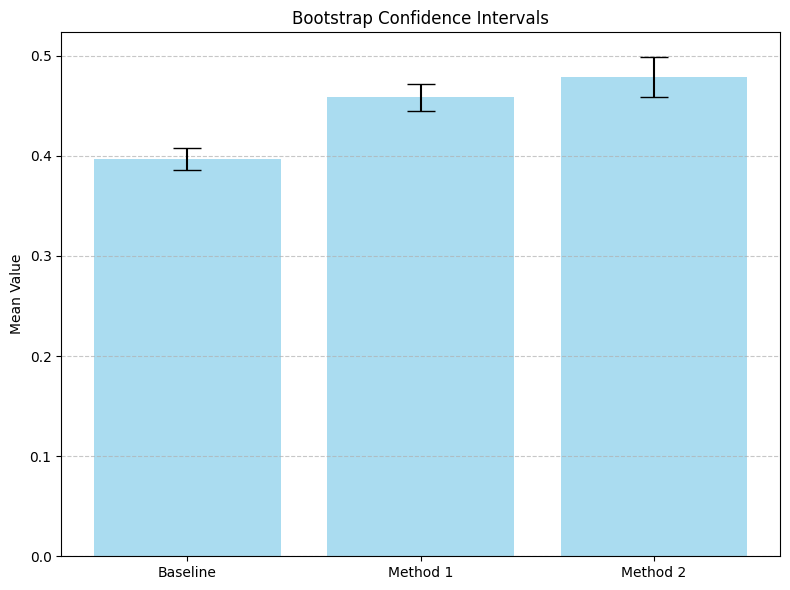

In [4]:
import matplotlib.pyplot as plt

# Compute mean of bootstrapped samples
method_names = ["Baseline", "Method 1", "Method 2"]
all_means = [baseline_means, method_1_means, method_2_means]
mean_estimates = [np.mean(means) for means in all_means]

# Calculate confidence intervals
ci_lower = [np.percentile(means, 2.5) for means in all_means]
ci_upper = [np.percentile(means, 97.5) for means in all_means]
error = [
    [m - l for m, l in zip(mean_estimates, ci_lower)],
    [u - m for m, u in zip(mean_estimates, ci_upper)],
]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(
    range(len(method_names)),
    mean_estimates,
    yerr=error,
    align="center",
    alpha=0.7,
    capsize=10,
    color="skyblue",
)
plt.xticks(range(len(method_names)), method_names)
plt.ylabel("Mean Value")
plt.title("Bootstrap Confidence Intervals")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("bootstrap.png")

## T-Testing

Now that we have the bootstrapped means, we can perform a t-test between the two methods to see if they are statistically significant. We'd ideally want to do so since we can see that from the bootstrap plot that the confidence intervals between the two methods have some overlap. Therefore we'd want to know if this difference is significant or just due to chance.

Doing a t-test ensures that we're doing a formal statistical analysis to check if the observed difference between the two methods is significant or not. Since the results we observed are calculated by using the same query input, we should use a paired t-test.

In [5]:
from scipy.stats import ttest_rel
import pandas as pd

df = pd.read_csv("./data.csv")

# Calculate the mean for each method
method_1 = df["method_1"].tolist()
method_2 = df["method_2"].tolist()
baseline = df["baseline"].tolist()

t_stat_baseline_method1, p_val_baseline_method1 = ttest_rel(baseline, method_1)
t_stat_baseline_method2, p_val_baseline_method2 = ttest_rel(baseline, method_2)
t_stat_method1_method2, p_val_method1_method2 = ttest_rel(method_1, method_2)

In [6]:
# Create a DataFrame with the t-test results
results_df = pd.DataFrame(
    {
        "Comparison": ["Baseline vs M1", "Baseline vs M2", "M1 vs M2"],
        "T statistic": [
            t_stat_baseline_method1,
            t_stat_baseline_method2,
            t_stat_method1_method2,
        ],
        "P Value": [
            p_val_baseline_method1,
            p_val_baseline_method2,
            p_val_method1_method2,
        ],
    }
)

# Format the numeric columns
results_df["T statistic"] = results_df["T statistic"].round(2)
results_df["P Value"] = results_df["P Value"].map("{:.2e}".format)

# Display the DataFrame with clean formatting
print(results_df.to_string(index=False))


    Comparison  T statistic  P Value
Baseline vs M1        -7.42 3.30e-12
Baseline vs M2        -6.91 6.55e-11
      M1 vs M2        -1.59 1.14e-01


# Indomee

We've seen that this was a relatively simple task to perform with just `numpy` and `pandas`. Now let's see how we can achieve the same results with `indomee`.

## Calculating Metrics

`indomee` provides functions to calculate various metrics such as Mean Reciprocal Rank (MRR) and Recall. 

Note here that your values in the list can be any value type. Under the hood, we're just using a `==` comparison to determine equality. **Most importantly, they should all be of the same type.**

Currently we only support these two metrics. We can see them being calculated below.

In [10]:
from indomee import calculate_mrr, calculate_recall

mrr = calculate_mrr(["apple", "banana", "orange"], ["banana", "orange", "grape"])
print("MRR:", mrr)
# > MRR: 0.5

# Calculate Recall
recall = calculate_recall(["apple", "banana", "orange"], ["banana"])
print("Recall:", recall)
# > Recall: 1

MRR: 0.5
Recall: 1.0


Another useful feature is that we can calculate the metrics at specific k values.

So for instance, for the list ["cat", "dog", "fish", "bird", "hamster"] where "fish" is our label,

Calculating metrics at different k values will give us different results since the label appears in the third position

`indomee` allows you to do so out of the box with the `calculate_metrics_at_k` function.

In [14]:
from indomee import calculate_metrics_at_k
from rich import print

metrics = calculate_metrics_at_k(
    metrics=["recall"],
    preds=["cat", "dog", "fish", "bird", "hamster"],
    labels=["fish"],
    k=[1, 2, 3, 4, 5],
)


for metric in metrics:
    print(f"- {metric} -> {metrics[metric]}")

- recall@1 -> 0.0

- recall@2 -> 0.0

- recall@3 -> 1.0

- recall@4 -> 1.0

- recall@5 -> 1.0

This is useful because when you're evaluating different models, you'll often want to know how your model performs at different k values.

This is closely tied to the business logic that you're executing.

A search engine might care that a relevant result is returned withi the first 25 entires but a recomendation system or RAG system might prioritize recall@5-10 instead

**Being able to calculate these metrics at different k values is crucial in seeing how your model/system performs**

## Bootstrapping

`indomee` provides an equivalent `bootstrap_from_results` function that performs the bootstrapping for you. 

In order to bootstrap the values for our baseline, method 1 and method 2, we can just get the relevant columns from our dataframe and pass them into the function.

In [12]:
from indomee import bootstrap_from_results
from rich import print

baseline_means = bootstrap_from_results(df["baseline"].tolist())
method_1_means = bootstrap_from_results(df["method_1"].tolist())
method_2_means = bootstrap_from_results(df["method_2"].tolist())

# print(baseline_means)
# print(method_1_means)
print(method_2_means)


BootstrapMetric(
    name='bootstrap_metric',
    value=0.47800829518587357,
    ci_lower=0.4582167411327398,
    ci_upper=0.498828905051887
)

The beauty of using `indomee` is that 

1. The bootstrapping is already implemented for you, just choose the number of samples and the sample size per draw
2. We automatically compute the lower and upper confidence intervals for you, making it easy to plot



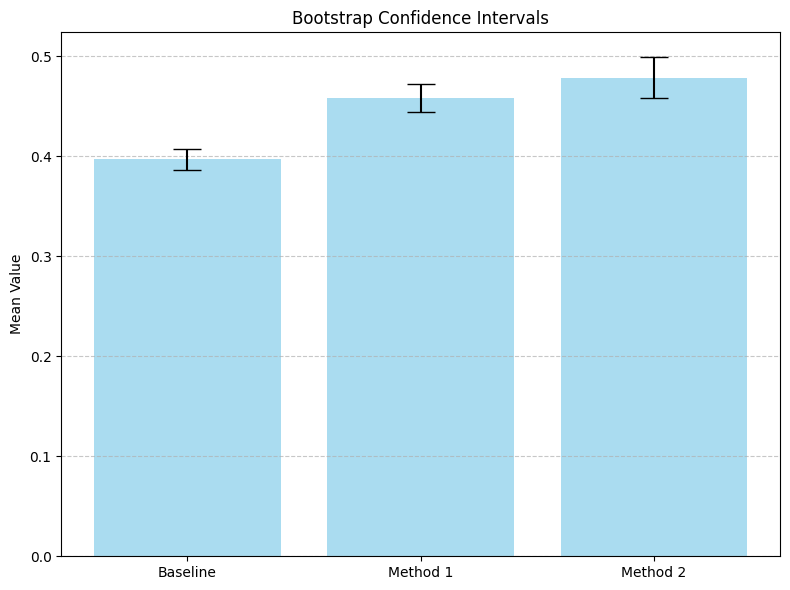

In [13]:
import matplotlib.pyplot as plt

# We already have the means and CIs computed for us so we just need to read them out
method_names = ["Baseline", "Method 1", "Method 2"]
mean_estimates = [baseline_means.value, method_1_means.value, method_2_means.value]
ci_lower = [baseline_means.ci_lower, method_1_means.ci_lower, method_2_means.ci_lower]
ci_upper = [baseline_means.ci_upper, method_1_means.ci_upper, method_2_means.ci_upper]

# Calculate error bars
error = [
    [m - l for m, l in zip(mean_estimates, ci_lower)],
    [u - m for m, u in zip(mean_estimates, ci_upper)],
]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(
    range(len(method_names)),
    mean_estimates,
    yerr=error,
    align="center",
    alpha=0.7,
    capsize=10,
    color="skyblue",
)
plt.xticks(range(len(method_names)), method_names)
plt.ylabel("Mean Value")
plt.title("Bootstrap Confidence Intervals")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("bootstrap.png")

### Bootstrapping with Raw Data

The real beauty of using `indomee` is that we can pass in the raw data itself and have full transparency over the entire process. 

You can either `bootstrap_sample` which will return a single sample of the bootstrapped data or `bootstrap` which will a summarised version of the entire bootstrapping process.

Under the hood, `indomee` uses the `bootstrap_sample` function to perform the `bootstrap` call.

In [15]:
from indomee import bootstrap_sample, bootstrap

# Bootstrapping a sample
result = bootstrap_sample(
    preds=[["a", "b"], ["c", "d"], ["e", "f"]],
    labels=[["a", "b"], ["c", "d"], ["e", "f"]],
    sample_size=10,
    metrics=["recall"],
    k=[1, 2, 3],
)
print("Bootstrap Sample Metrics:", result.sample_metrics)


Bootstrap Sample Metrics:
{
    'recall@1': BootstrapMetric(
        name='recall@1',
        value=np.float64(0.5),
        ci_lower=np.float64(0.5),
        ci_upper=np.float64(0.5)
    ),
    'recall@2': BootstrapMetric(
        name='recall@2',
        value=np.float64(1.0),
        ci_lower=np.float64(1.0),
        ci_upper=np.float64(1.0)
    ),
    'recall@3': BootstrapMetric(
        name='recall@3',
        value=np.float64(1.0),
        ci_lower=np.float64(1.0),
        ci_upper=np.float64(1.0)
    )
}

In [19]:
from indomee import bootstrap

# Bootstrapping multiple samples
result = bootstrap(
    preds=[["a", "b"], ["c", "d"], ["e", "f"]],
    labels=[["a", "b"], ["c", "d"], ["e", "f"]],
    n_samples=2,
    sample_size=10,
    metrics=["recall"],
    k=[1, 2, 3],
)
print("Bootstrap Metrics:", result)

Bootstrap Metrics:
BootstrapResult(
    samples=[
        BootstrapSample(
            samples=[
                Sample(pred=['c', 'd'], gt=['c', 'd']),
                Sample(pred=['e', 'f'], gt=['e', 'f']),
                Sample(pred=['e', 'f'], gt=['e', 'f']),
                Sample(pred=['a', 'b'], gt=['a', 'b']),
                Sample(pred=['a', 'b'], gt=['a', 'b']),
                Sample(pred=['a', 'b'], gt=['a', 'b']),
                Sample(pred=['c', 'd'], gt=['c', 'd']),
                Sample(pred=['a', 'b'], gt=['a', 'b']),
                Sample(pred=['e', 'f'], gt=['e', 'f']),
                Sample(pred=['a', 'b'], gt=['a', 'b'])
            ],
            sample_metrics={
                'recall@1': BootstrapMetric(
                    name='recall@1',
                    value=np.float64(0.5),
                    ci_lower=np.float64(0.5),
                    ci_upper=np.float64(0.5)
                ),
                'recall@2': BootstrapMetric(
                    name='recall@2',
                    value=np.float64(1.0),
                    ci_lower=np.float64(1.0),
                    ci_upper=np.float64(1.0)
                ),
                'recall@3': BootstrapMetric(
                    name='recall@3',
                    value=np.float64(1.0),
                    ci_lower=np.float64(1.0),
                    ci_upper=np.float64(1.0)
                )
            }
        ),
        BootstrapSample(
            samples=[
                Sample(pred=['e', 'f'], gt=['e', 'f']),
                Sample(pred=['e', 'f'], gt=['e', 'f']),
                Sample(pred=['c', 'd'], gt=['c', 'd']),
                Sample(pred=['a', 'b'], gt=['a', 'b']),
                Sample(pred=['e', 'f'], gt=['e', 'f']),
                Sample(pred=['a', 'b'], gt=['a', 'b']),
                Sample(pred=['e', 'f'], gt=['e', 'f']),
                Sample(pred=['e', 'f'], gt=['e', 'f']),
                Sample(pred=['e', 'f'], gt=['e', 'f']),
                Sample(pred=['c', 'd'], gt=['c', 'd'])
            ],
            sample_metrics={
                'recall@1': BootstrapMetric(
                    name='recall@1',
                    value=np.float64(0.5),
                    ci_lower=np.float64(0.5),
                    ci_upper=np.float64(0.5)
                ),
                'recall@2': BootstrapMetric(
                    name='recall@2',
                    value=np.float64(1.0),
                    ci_lower=np.float64(1.0),
                    ci_upper=np.float64(1.0)
                ),
                'recall@3': BootstrapMetric(
                    name='recall@3',
                    value=np.float64(1.0),
                    ci_lower=np.float64(1.0),
                    ci_upper=np.float64(1.0)
                )
            }
        )
    ],
    sample_metrics={
        'recall@1': BootstrapMetric(
            name='recall@1',
            value=np.float64(0.5),
            ci_lower=np.float64(0.5),
            ci_upper=np.float64(0.5)
        ),
        'recall@2': BootstrapMetric(
            name='recall@2',
            value=np.float64(1.0),
            ci_lower=np.float64(1.0),
            ci_upper=np.float64(1.0)
        ),
        'recall@3': BootstrapMetric(
            name='recall@3',
            value=np.float64(1.0),
            ci_lower=np.float64(1.0),
            ci_upper=np.float64(1.0)
        )
    }
)

Under the hood, we can see that `indomee` performs the bootstrap but you have full access to

1. The raw samples that were chosen for each individual iteration of the bootstrap
2. The metrics that were calculated for each individual iteration of the bootstrap
3. The summary statistic of the bootstrapping process

This makes it easy for you to perform any additional analysis on the raw data itself because we don't hide any of the data from you.

## T-Testing

The t-test is a statistical method that helps us determine if the differences we observe between two methods are statistically significant or just due to random chance. 

When we look at our bootstrap plots, we can see some overlap in the confidence intervals between methods. While this gives us a visual indication, the t-test provides a formal statistical framework to quantify this difference:

1. The t-test calculates a t-statistic and p-value:
   - The t-statistic measures how many standard deviations the difference between means is from zero
   - The p-value tells us the probability of observing such a difference if there was actually no real difference between the methods

2. We use a paired t-test here because:
   - Our measurements are related (same queries used for each method)
   - Each data point in one method has a natural pairing with a data point in the other method
   - This helps control for query-specific variations

`indomee` provides a simple interface for this analysis - just specify whether you want a paired test (default) or unpaired test by setting the `paired` argument:

In [2]:
from indomee import perform_t_tests
import pandas as pd

df = pd.read_csv("./data.csv")

# Calculate the mean for each method
method_1 = df["method_1"].tolist()
method_2 = df["method_2"].tolist()
baseline = df["baseline"].tolist()

results = perform_t_tests(
    baseline, method_1, method_2,
    names=["Baseline", "Method 1", "Method 2"],
    paired=True,
)
results

,population_1,population_2,t_statistic,p_value,significant
0,Baseline,Method 1,-7.42,3.30e-12,True
1,Baseline,Method 2,-6.91,6.55e-11,True
2,Method 1,Method 2,-1.59,1.14e-01,False
